In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = pd.read_csv('../Data/df_skill.csv')
data.drop('Unnamed: 0',axis = 1,inplace=True)

In [3]:
data.drop(['microsoft_office', 'microsoft_word', 'microsoft_excel', 'management', 'project_management','change_management'], axis = 1, inplace=True)

In [4]:
freq = (data>0).apply(sum).values
data = data * (1/(1+np.log(freq)))

drop_list = []
for i in range(len(freq)):
    if freq[i] == 1:
        drop_list.append(data.columns[i])
data.drop(drop_list, axis = 1, inplace=True)

In [5]:
data.shape

(40000, 5985)

In [54]:
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 5985 entries, seo_copywriting to security_law
dtypes: float64(5985)
memory usage: 1.8 GB


In [2]:
data = pd.read_csv('skill_vectors.csv')

In [3]:
data.shape

(6804, 100)

In [6]:
#tf_data = tf.constant(data.values, dtype=tf.float32)

In [4]:
learning_rate = 0.01
training_epochs = 10
batch_size = 400
display_step = 1
examples_to_show = 10

In [11]:
n_input = data.shape[1]

X = tf.placeholder(tf.float32,[None, n_input])

n_hidden_layer1 = 64#1024
n_hidden_layer2 = 8#256
n_hidden_layer3 = 2#64
#n_hidden_layer4 = 8
#n_hidden_layer5 = 2


In [12]:
weights = {
    'encoder_w1':tf.Variable(tf.random_normal([n_input, n_hidden_layer1])),
    'encoder_w2':tf.Variable(tf.random_normal([n_hidden_layer1, n_hidden_layer2])),
    'encoder_w3':tf.Variable(tf.random_normal([n_hidden_layer2, n_hidden_layer3])),
    #'encoder_w4':tf.Variable(tf.random_normal([n_hidden_layer3, n_hidden_layer4])),#
    #'encoder_w5':tf.Variable(tf.random_normal([n_hidden_layer4, n_hidden_layer5])),#
    
    #'decoder_w1':tf.Variable(tf.random_normal([n_hidden_layer5, n_hidden_layer4])),#
    #'decoder_w2':tf.Variable(tf.random_normal([n_hidden_layer4, n_hidden_layer3])),#
    #'decoder_w3':tf.Variable(tf.random_normal([n_hidden_layer3, n_hidden_layer2])),#
    #'decoder_w4':tf.Variable(tf.random_normal([n_hidden_layer2, n_hidden_layer1])),#
    #'decoder_w5':tf.Variable(tf.random_normal([n_hidden_layer1, n_input])),#
    'decoder_w1':tf.Variable(tf.random_normal([n_hidden_layer3, n_hidden_layer2])),
    'decoder_w2':tf.Variable(tf.random_normal([n_hidden_layer2, n_hidden_layer1])),
    'decoder_w3':tf.Variable(tf.random_normal([n_hidden_layer1, n_input])),
}

biases = {
    'encoder_b1':tf.Variable(tf.random_normal([n_hidden_layer1])),
    'encoder_b2':tf.Variable(tf.random_normal([n_hidden_layer2])),
    'encoder_b3':tf.Variable(tf.random_normal([n_hidden_layer3])),
    #'encoder_b4':tf.Variable(tf.random_normal([n_hidden_layer4])),#
    #'encoder_b5':tf.Variable(tf.random_normal([n_hidden_layer5])),#
    
    #'decoder_b1':tf.Variable(tf.random_normal([n_hidden_layer4])),#
    #'decoder_b2':tf.Variable(tf.random_normal([n_hidden_layer3])),#
    #'decoder_b3':tf.Variable(tf.random_normal([n_hidden_layer2])),#
    #'decoder_b4':tf.Variable(tf.random_normal([n_hidden_layer1])),#
    #'decoder_b5':tf.Variable(tf.random_normal([n_input])),#
    'decoder_b1':tf.Variable(tf.random_normal([n_hidden_layer2])),
    'decoder_b2':tf.Variable(tf.random_normal([n_hidden_layer1])),
    'decoder_b3':tf.Variable(tf.random_normal([n_input])),
}

In [13]:
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_w1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_w2']), biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_w3']), biases['encoder_b3']))
    #layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['encoder_w4']), biases['encoder_b4']))#
    #layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, weights['encoder_w5']), biases['encoder_b5']))#
    #return layer_5#
    return layer_3

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_w1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_w2']), biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_w3']), biases['decoder_b3']))
    #layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['decoder_w4']), biases['decoder_b4']))#
    #layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, weights['decoder_w5']), biases['decoder_b5']))#
    #return layer_5
    return layer_3

In [14]:
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

y_pred = decoder_op
y_true = X

cost = tf.reduce_mean(tf.pow(y_pred - y_true, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [21]:
%%time
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    n_batch = int(data.shape[0]/batch_size)
    for epoch in tqdm(range(training_epochs)):
        for batch_idx in range(n_batch):
            start = batch_idx * batch_size
            stop = start + batch_size
            _, encoder_result = sess.run([optimizer, encoder_op], feed_dict={X: data[start:stop]})
    #print(sess.run(cost, feed_dict={X:data[start:stop]}))
    X_test = sess.run(encoder_op, feed_dict={X:data})

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21it/s]


Wall time: 1.19 s


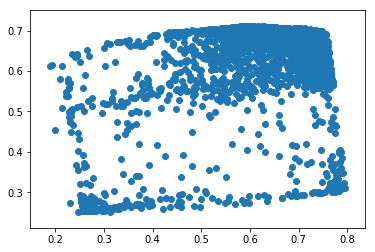

(6804, 2)

In [22]:
plt.scatter(X_test[:,0],X_test[:,1])
plt.show()
X_test.shape

In [14]:
#from sklearn.cluster import SpectralClustering
#clustering = SpectralClustering(n_clusters=2,assign_labels="discretize", random_state=0).fit(X_test)

In [23]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('../Utils/word2vec_model_allskills')

D:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [24]:
import dill as pickle
f = open("../Data/all_top_skills_final_fre.txt","rb")
key_list = pickle.load(f)
f.close()


skill_list = []
for i in key_list.keys():
    try: 
        model[i]
        skill_list.append(i)
    except:
        pass

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [26]:
from sklearn.cluster import AgglomerativeClustering
clustering_agg = AgglomerativeClustering(n_clusters=50,linkage='average')

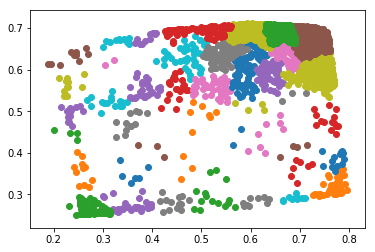

In [47]:
result_agg = clustering_agg.fit_predict(X_test)
for i in range(50):
    list_x = []
    list_y = []
    for j in range(len(result_agg)):
        if result_agg[j] == i:
            list_x.append(X_test[j,0])
            list_y.append(X_test[j,1])
    plt.scatter(list_x,list_y)
plt.show()

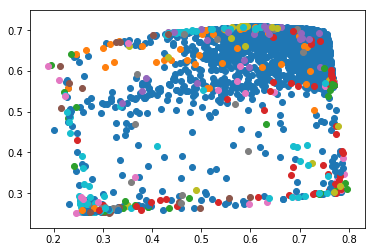

In [55]:
clustering_agg = AgglomerativeClustering(n_clusters=50,linkage='average')
result_agg = clustering_agg.fit_predict(data)
for i in range(50):
    list_x = []
    list_y = []
    for j in range(len(result_agg)):
        if result_agg[j] == i:
            list_x.append(X_test[j,0])
            list_y.append(X_test[j,1])
    plt.scatter(list_x,list_y)
plt.show()

In [48]:
from collections import Counter
skill_counts = Counter(result_agg)
top_three = skill_counts.most_common(3)
top_three

[(38, 3647), (35, 922), (42, 735)]

In [49]:
for i in range(50):
    if i != top_three[0][0]:
        list_temp = []
        for j in range(len(result_agg)):
            if result_agg[j] == i:
                list_temp.append(skill_list[j])
        print(list_temp)
        print("  ")

['speaking_in_public', 'btob_marketing', 'history', 'statistics', 'higher_education', 'branding_&_identity']
  
['marketing_research', 'sea', 'graphics', 'photoshop', 'graphisme', 'channel_partners', 'sales_process', 'web_design', 'radio', 'solution_selling', 'graphic_design']
  
['business_finance', 'hospitality_industry', 'budget_management', 'microsoft_powerpoint', 'strategic_consulting', 'budgets', 'hotel', 'product_development', 'talks', 'food_&_beverage', 'hospitality_sector', 'p&l_management']
  
['umts', 'unified_communications', 'film_production', 'digital_photography', 'psychology', 'data_management', 'web', 'advertising_referencing', 'lead_generation', 'postproduction', 'sketch', 'twitter', 'news_writing', 'cultural_heritage', 'digital', 'user-centered_design', 'museums', 'sales_enablement', 'video_games', 'recruitment_advertising', 'fashion_design']
  
['accounting', 'trade_marketing', 'communication_on_social_networks', 'selling_process', 'research', 'recruitment', 'luxury

['process_management', 'electricity', 'heating_ventilation_air_conditioning', 'european_politics', 'military', 'work_relations', 'wind', 'lean_six_sigma', 'geotechnical_engineering', 'engineering_management', 'thermodynamique', 'accounting_holding', 'sensors', 'strategic_sourcing', 'concrete', 'security_management', 'quality_improvement', 'power_generation', 'cost_accounting', 'climate_change', 'supplier_development', 'drilling_engineering', 'intercultural_communication', 'manufacturing', 'health_safety_environment', 'stress_management', 'automate_programmable', 'consolidation', 'haccp', 'urbanism', 'diversity_and_integration', 'geophysics', 'energy_markets', 'rail_transport', 'drilling', 'management_control', 'structural_analysis', 'routes', 'technology_transfer', 'adaptability', 'airlines', 'ptc_creo', 'surveying', 'interpersonal_skills', 'planification_urbaine', 'characterization', 'compensation_&_benefits', 'electricity_markets', 'fundraising', 'electric_vehicles', 'amdec', 'autoca

  
['user_test', 'leadership', 'statistical_modeling', 'content_management_systems_(cms)', 'campaign_management', 'management_services_it', 'distribution_partnership', 'executive_search', 'adobe_premiere', 'payments', 'enterprise_architecture', 'oop', 'user-oriented_design', 'human_computer_interaction', 'print', 'programmation_sas', 'marketing_multicanal', 'it_solutions', 'search_advertising', 'display_advertising', 'usability_testing', 'bank_cards', 'algorithms', 'responsive_web_design', 'analysis_of_statistical_data', 'solution_architecture', 'usability', 'information_technology', 'spss', 'media_buying', 'distributed_systems', 'reporting_&_analysis']
  
['master_data_management', 'sales_and_marketing', 'hr_transformation', 'invoice_processing', 'international_business_development', 'montage', 'qos', 'trend_analysis', 'visual_identity', 'localization', 'b_permit', 'text_correction', 'transmission', 'inbound_marketing', 'business_process_re-engineering', 'scene', 'festival', 'strategi

['music', 'client_satisfaction', 'production_management', 'direct_marketing', 'video_montage', 'service_client', 'sales_operations', 'magazines', 'customer_relationship_management_(crm)', 'web_marketing', 'digital_strategy', 'photographie', 'sale', 'market_analysis', 'market_research', 'sponsorship', 'corporate_events', 'adobe_photoshop', 'b2b', 'product_innovation', 'online_marketing', 'entrepreneurship', 'recruiting', 'creative_writing', 'crm', 'seo', 'sem', 'sale_of_solutions', 'communication_interne', 'video', 'web_analytics', 'customer_experience', 'new_media', 'events_organisation', 'sports_marketing', 'account_management', 'marketing_digital', 'communication_marketing', 'bank', 'luxury', 'analytics', 'sales_management', 'marketing', 'competitive_analysis', 'marketing_par_e-mail', 'strategic_communication', 'consulting', 'go-to-market_strategy', 'television', 'edition', 'start-ups', 'sport', 'business_development', 'customer_satisfaction', 'prospection', 'sales', 'advertising', '

['stock_options', 'classification', 'engineering_training', 'process_safety', 'derivatives', 'economic_intelligence', 'jms', 'employee_relations', 'communication_rh', 'virtual_private_network_(vpn)', 'consumer_law', 'clinical_development', 'rf', 'rh', 'collective_bargaining', 'intercultural_skills', 'shared_services', 'aircraft_systems', 'global_delivery', 'sap_mm', 'prevention', 'caml', 'electrical_installation', 'anti_money_laundering', 'irp', 'requirements_management', 'carbon', 'profit_center_management', 'gestion_administrative', 'trading_strategies', 'hr_project_management', 'management_transversal', 'foreign_exchange_options', 'robot_programming', 'fortran', 'account_reconciliation', 'fault_tree_analysis', 'fpga', 'talend_open_studio', 'corporate_governance', 'humanitarian_assistance', 'national_instruments_labview', 'asterisk', 'teacher_training', 'equity_capital_markets', 'mass_spectrometry', 'market_risk', 'confidentiality', 'vulnerability_management', 'personnel_administrati

  
['production_musicale', 'marketing_studies', 'records_management', 'documentaries', 'visual_communication', 'fine_arts', 'imovie', 'publications', 'architecture', 'strategic_partnerships', 'web_marketing_strategy', 'educational_engineering', 'the_history_of_art', 'performing_arts', 'theater', 'prezi', 'illustrator', 'mathematics', 'instagram', 'communications_strategy', 'selling', 'it_service_management', 'art_history', 'quantitative_research', 'partnership_management', 'small_business', 'theatre', 'textile', 'online_formation', 'communication_digitale', 'engineering', 'visual_arts', 'networking_social', 'concept_design', 'strategic_watch', 'tradeshow', 'short_films', 'events', 'operational_marketing', 'resource_management']
  
['project_planning', 'project_coordination', 'logistics', 'achats', 'restaurant', 'pricing', 'hotel_management', 'hospitality_management', 'relations_internationales']
  
['soa', 'clitoris', 'omniture', 'software_engineering', 'enterprise_software', 'wirefram

['ejb', 'cobit', 'lora', 'global_mobility', 'humanities_and_social_sciences', 'reporting_adhoc', 'outils_uml', 'mechanical_testing', 'staff_management', 'life_insurance', 'glass', 'mobile_content', 'tribology', 'organized', 'semiconductor_industry', 'cisco_certified', 'environmental_reporting', 'amesim', 'real-time_operating_system', 'visual_management', 'training_evaluation', 'spss_clementine', 'international_taxation', 'hoshin', 'doors', 'orientation_client', 'lpm', 'software_configuration_management', 'hierarchical_and_functional_management', 'debt_recovery', 'job_search_techniques', 'electronics_hardware_design', 'criminal_justice', 'hammer', 'graph_databases', 'general_management', 'mcafee', 'airflow', 'film_selection', 'cisco_ios', 'civil_aviation', 'international_m&a', 'qlik_sense', 'financial_regulation', 'symfony_framework', 'application_security', 'brokerage', 'kotlin', 'prevention_plan', 'soc', 'sop', 'climate_engineering', 'computational_mechanics', 'it_project_leadership',

  
['salesforce.com_consulting', 'periscope_data', 'network_administration', 'hibernate', 'sas', 'qlikview', 'system_administrator', 'oracle', 'database_design', 'asp.net', 'credit_cards', 'tcp/ip', 'continuous_integration', 'with_a', 'ruby_on_rails', 'object_oriented_programming_(oop)', 'optical_fiber', 'linux_system_administration', 'linux', 'english_level_c1', 'fresh_ideas', 'videography', 'server_administration', 'virtualisation', 'agile', 'iptv', 'phpmyadmin', 'pl/sql', 'sdlc', 'agile_web_development', 'ios', 'software_design', 'bootstrap', 'git', 'webanalytics', 'script_shell', 'iphone', 'photojournalism', 'internet_strategy', 'payment_systems', 'nlp', 'interviews', 'informatica', 'react.js', '.net', 'pay_per_click_(ppc)', 'culture_web', 'sass']
  
['mysql', 'services_web', 'web_applications', 'web_services', 'android_development', 'etl', 'data_integration', 'site_development', 'drupal', 'data_modeling', 'java']
  
['web_2.0', 'programmation_web', 'big_data']
  
['analyse_des_rev

In [15]:
%%time
from sklearn.mixture import GaussianMixture
clustering = GaussianMixture(n_components=500,covariance_type='spherical',init_params='random').fit(X_test)

D:\Anaconda\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Wall time: 6min 57s


In [16]:
result = clustering.predict(X_test)
for i in range(500):
    if sum(result == i) > 0:
        print(str(sum(result == i))+"  "+str(i))

263  0
10  1
9  2
8  3
34  4
20  7
227  8
3  9
66  10
28  12
1  13
48  15
7  16
103  17
62  18
154  19
72  20
3  21
40  23
75  26
4  27
425  28
2  29
434  30
8  31
7  32
142  33
4  34
14  35
53  36
116  37
8  38
1  39
14  41
98  42
151  43
954  44
1  45
1  46
2  47
9  48
3  49
4  50
15  51
12  53
219  54
14  55
5  57
106  58
89  59
174  60
6  62
4  63
494  64
36  65
1  66
21  67
70  68
164  69
31  70
11  71
3  72
63  73
20  74
105  76
2  77
48  78
41  79
28  81
2  82
302  83
34  84
61  85
61  87
3  89
8  90
24  91
1614  92
4  94
17  96
5  97
18  98
1  99
2  100
111  102
56  103
91  104
8  105
9  106
19  107
40  108
55  109
35  110
23  111
105  112
94  113
108  114
10  116
1  118
21  119
54  120
53  121
60  122
5  123
85  124
13  125
177  126
40  127
30  128
52  129
1838  130
16  131
75  132
38  133
87  134
105  135
48  136
2  137
109  138
42  140
2  141
170  142
8  143
11  144
14  145
3  146
1  147
55  148
1  149
128  152
49  153
51  154
36  157
5  158
100  159
83  160
192  161
92  162

In [17]:
import bson
with open("../Data/linkedin_db/profile.bson",'rb') as f: 
    data_profile = bson.decode_all(f.read()) 
    f.close()

In [18]:
def show_skill(index):
    show = [[],[]]
    show[0].append('Top Skills: ')
    show[1].append('Other Skills: ')
    for skills in data_profile[index]['skills']:
        if skills['title'] == 'Top Skills':
            for skill in skills['skills']:
                show[0].append(skill['title'])
        else:
            for skill in skills['skills']:
                show[1].append(skill['title'])
    print(show[0])
    #print(show[1])
    return

In [52]:
import heapq
cluster1_index = []
for i in range(len(result)):
    if result[i] == 109:
        cluster1_index.append(i)

temp = np.zeros([data.shape[1]])
for i in cluster1_index:
    temp += data.loc[i].values 
    show_skill(i)

temp_list = temp.tolist()
max_index = heapq.nlargest(3, range(len(temp_list)), temp_list.__getitem__)
data.columns[max_index]

['Top Skills: ', 'Product Management', 'Telecommunications', 'Product Marketing']
['Top Skills: ', 'Réseaux infomatiques', 'Wireshark', 'VoIP']
['Top Skills: ', 'Social Media', 'Digital Marketing', 'Social Media Marketing']
['Top Skills: ', 'Higher Education', 'Curriculum Design', 'University Teaching']
['Top Skills: ', 'Business Analysis', 'Instant Payment', 'Payment Systems']
['Top Skills: ', 'Python', 'Cobol', 'C++']
['Top Skills: ', 'Business Strategy', 'Mobile Devices', 'Product Management']
['Top Skills: ', 'Conformité', 'Bancassurance', 'Assurance de biens']
['Top Skills: ', 'Java', 'C', 'OCaml']
['Top Skills: ', 'Motion Design', 'Python', 'After Effects']
['Top Skills: ', 'Matlab', 'Bioinformatics', 'Python']
['Top Skills: ', 'Object Oriented Design', 'Network Engineering', 'Java']
['Top Skills: ', 'Project Management', 'Cybersecurity', 'HKMA']
['Top Skills: ', 'Secteur hôtellerie', 'Service client', 'Restauration']
['Top Skills: ', 'Télécommunications', 'GSM', 'Telecommunicati

Index(['marketing_strategy', 'project_management', 'public_relations'], dtype='object')

In [44]:
key_list.keys()

dict_keys(['seo_copywriting', 'sme_management', 'business_finance', 't_wood', 'ejb', 'cobit', 'process_management', 'elevator_pitch', 'electricity', 'scheduling_of_production_workshops', 'specialiste_thermoformage_corian®_/_staron', 'lora', 'engagement_principles', 'realization_of_a_diagnosis_of_the_stakes_of_power_in_the_zones_of_conflicts', 'stock_options', 'judicial_expertise', 'strategic_marketing', 'heating_ventilation_air_conditioning', 'european_politics', 'umts', 'brand_consulting', 'ionic_framework', 'croatian', 'persuasion_ability', 'global_mobility', 'formation_coach_&_team', 'internal_&_external_communications', 'humanities_and_social_sciences', 'open_innovation', 'ansible_tower', 'mlm', 'musical_ensemble', 'plant_biology', 'team_coordination_and_coaching', 'programming:_c,_java,_c_#,_assembler,_sql,_html5,_css,_javascript.', 'energy_production', 'reporting_adhoc', 'write_and_show_ads', 'diagnostic_methodology', 'meeting_planning', 'outils_uml', 'salesforce.com_consulting',

In [38]:
sorted(key_list.items(),key=lambda item:item[1],reverse=True)

[('management', 7550),
 ('project_management', 5716),
 ('microsoft_office', 4127),
 ('change_management', 2281),
 ('microsoft_excel', 2257),
 ('marketing', 1988),
 ('java', 1330),
 ('english', 1131),
 ('human_resources', 1112),
 ('microsoft_word', 961),
 ('team_management', 935),
 ('marketing_strategy', 867),
 ('strategy', 822),
 ('communication', 809),
 ('python', 698),
 ('customer_service', 681),
 ('recruitment', 681),
 ('leadership', 679),
 ('engineering', 639),
 ('business_development', 624),
 ('commercial_strategy', 601),
 ('french', 577),
 ('telecommunications', 570),
 ('business_strategy', 551),
 ('sql', 532),
 ('powerpoint', 503),
 ('social_networks', 493),
 ('matlab', 492),
 ('finance', 485),
 ('talks', 479),
 ('public_relations', 477),
 ('c', 476),
 ('risk_management', 463),
 ('c++', 445),
 ('machine_learning', 425),
 ('teamwork', 413),
 ('financial_analysis', 407),
 ('transport', 402),
 ('energy', 398),
 ('e-commerce', 393),
 ('sourcing', 388),
 ('communication_marketing', 3

In [37]:
import dill as pickle
f = open("../Data/all_top_skills_final_fre.txt","rb")
key_list = pickle.load(f)
f.close()

In [46]:
temp_list.index

<function list.index>

In [50]:
import heapq
max_index = heapq.nlargest(3, range(len(temp_list)), temp_list.__getitem__)
max_index

[2210, 904, 1011]

In [ ]:
list(temp)

In [ ]:
freq = (data>0).apply(sum).values
data = data * (1/(1+np.log(freq)))

In [ ]:
data.columns[freq.tolist().index(freq.max())]

In [ ]:
(1/(1+np.log(freq))).max()

In [ ]:
data = data * (1/(1+np.log(freq)))

In [ ]:
data